# Restaurant location

Kaggle competition https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting
    
Test if a KMeans clustering algorithm applied to latitude-longitude data leads to the cities listed in area_name

In [1]:
import pylab as py
import pandas as pandas
%matplotlib inline
import datetime
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
data_store_air = pandas.read_csv('Data/air_store_info.csv')
data_store_hpg = pandas.read_csv('Data/hpg_store_info.csv')
data_store_relations = pandas.read_csv('Data/store_id_relation.csv')

In [3]:
stores = data_store_air.merge(data_store_relations, on='air_store_id', how='left')
stores = stores.merge(data_store_hpg, on='hpg_store_id', how='outer', suffixes=('_air','_hpg'))

# Organizing area information

In [4]:
def get_area_hierarchy(area_name):
    if not isinstance(area_name, str):
        return []
    split = area_name.split(' ')
    hierarchy = []
    if split[1] == 'Prefecture':
        split[0] = ' '.join(split[0:2])
        split.pop(1)
    for name in split:
        if name.lower() != 'none':
            hierarchy.append(name)
    hierarchy = [x for x in hierarchy if x.lower()!='none']
    return hierarchy
test = stores['hpg_area_name'].apply(get_area_hierarchy)
stores['hpg_area_city'] = [x[0] if len(x)>0 else None for x in test]
stores['hpg_area_district'] = [x[1] if len(x)>1 else None for x in test]
stores['hpg_area_extra'] = [' '.join(x[2:]) if len(x)>2 else None for x in test]
test = stores['air_area_name'].apply(get_area_hierarchy)
stores['air_area_city'] = [x[0] if len(x)>0 else None for x in test]
stores['air_area_district'] = [x[1] if len(x)>1 else None for x in test]
stores['air_area_extra'] = [' '.join(x[2:]) if len(x)>2 else None for x in test]



In [5]:
stores['air_area_city'].describe()

count          829
unique           9
top       Tōkyō-to
freq           444
Name: air_area_city, dtype: object

The names of cities and districts are uniques (i.e., there is no case of two districts with the same name in two different cities).

In [6]:
stores['air_area_city'].value_counts()

Tōkyō-to         444
Fukuoka-ken      127
Ōsaka-fu          74
Hyōgo-ken         57
Hokkaidō          46
Hiroshima-ken     32
Shizuoka-ken      18
Miyagi-ken        17
Niigata-ken       14
Name: air_area_city, dtype: int64

In [7]:
stores['hpg_area_city'].value_counts()

Tōkyō-to            2076
Ōsaka-fu             514
Fukuoka-ken          380
Hyōgo-ken            331
Hokkaidō             298
Hiroshima-ken        245
Shizuoka-ken         231
Osaka Prefecture     145
Niigata-ken          142
Miyagi-ken           139
Kanagawa-ken          61
Saitama-ken           11
Name: hpg_area_city, dtype: int64

In [8]:
stores['lat'] = stores.apply(lambda x: x['latitude_air'] if not py.isnan(x['latitude_air']) else x['latitude_hpg'], axis=1)
stores['lng'] = stores.apply(lambda x: x['longitude_air'] if not py.isnan(x['longitude_air']) else x['longitude_hpg'], axis=1)

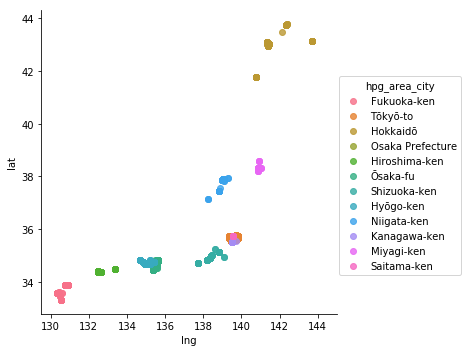

In [9]:
sns.lmplot(y='lat', x='lng', data=stores, fit_reg=False, hue='hpg_area_city')

# KMeans clustering algorithm

From the map, it seems a good idea to divide the map into 8 regions.

In [10]:
model = KMeans(n_clusters=8)
predicted = model.fit_predict(stores[['lat','lng']])

In [11]:
stores['predicted_region'] = predicted

In [12]:
for i in range(8):
    data = stores[stores['predicted_region']==i]
    print('\n',i,'\n',data['air_area_city'].value_counts(),'\n',data['hpg_area_city'].value_counts())


 0 
 Tōkyō-to    444
Name: air_area_city, dtype: int64 
 Tōkyō-to        2076
Kanagawa-ken      61
Saitama-ken       11
Name: hpg_area_city, dtype: int64

 1 
 Hiroshima-ken    32
Name: air_area_city, dtype: int64 
 Hiroshima-ken    245
Name: hpg_area_city, dtype: int64

 2 
 Hokkaidō    46
Name: air_area_city, dtype: int64 
 Hokkaidō    298
Name: hpg_area_city, dtype: int64

 3 
 Ōsaka-fu     74
Hyōgo-ken    57
Name: air_area_city, dtype: int64 
 Ōsaka-fu            514
Hyōgo-ken           331
Osaka Prefecture    145
Name: hpg_area_city, dtype: int64

 4 
 Fukuoka-ken    127
Name: air_area_city, dtype: int64 
 Fukuoka-ken    380
Name: hpg_area_city, dtype: int64

 5 
 Miyagi-ken    17
Name: air_area_city, dtype: int64 
 Miyagi-ken    139
Name: hpg_area_city, dtype: int64

 6 
 Niigata-ken    14
Name: air_area_city, dtype: int64 
 Niigata-ken    142
Name: hpg_area_city, dtype: int64

 7 
 Shizuoka-ken    18
Name: air_area_city, dtype: int64 
 Shizuoka-ken    231
Name: hpg_area_city, d

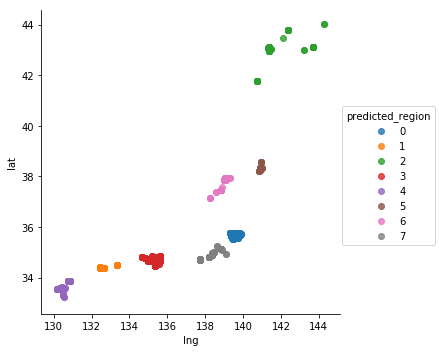

In [13]:
sns.lmplot(y='lat', x='lng', data=stores, fit_reg=False, hue='predicted_region')

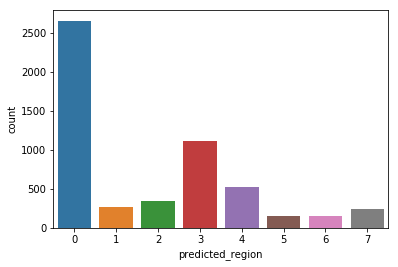

In [15]:
sns.countplot(x='predicted_region', data=stores)

[]

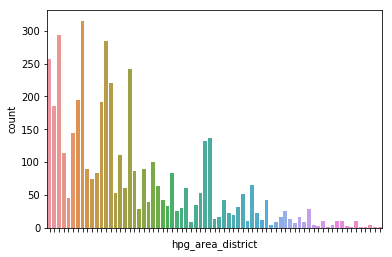

In [16]:
ax = sns.countplot(x='hpg_area_district', data=stores)
ax.set_xticklabels([])

In [17]:
stores[['air_area_city','hpg_area_city']].describe()

,air_area_city,hpg_area_city
count,829,4573
unique,9,12
top,Tōkyō-to,Tōkyō-to
freq,444,2076


In [18]:
stores[['air_area_district','hpg_area_district']].describe()

,air_area_district,hpg_area_district
count,829,4564
unique,55,71
top,Fukuoka-shi,Ōsaka-shi
freq,103,315


In [19]:
stores[['air_area_extra','hpg_area_extra']].describe()

,air_area_extra,hpg_area_extra
count,826,3104
unique,99,99
top,Daimyō,Ginza
freq,64,198


In [20]:
for dist in stores['hpg_area_district'].unique():
    d = stores[stores['hpg_area_district']==dist]
    city_unique = len(d['hpg_area_city'].unique())
    if city_unique!=1:
        print(city_unique,dist)

0 None


In [21]:
for extra in stores['hpg_area_extra'].unique():
    d = stores[stores['hpg_area_extra']==extra]
    city_unique = len(d['hpg_area_city'].unique())
    dist_unique = len(d['hpg_area_district'].unique())
    if city_unique!=1 or dist_unique!=1:
        print(city_unique,dist_unique,extra)

0 0 None


In [22]:
for dist in stores['air_area_district'].unique():
    d = stores[stores['air_area_district']==dist]
    city_unique = len(d['air_area_city'].unique())
    if city_unique!=1:
        print(city_unique,dist)

0 None


In [23]:
for extra in stores['air_area_extra'].unique():
    d = stores[stores['air_area_extra']==extra]
    city_unique = len(d['air_area_city'].unique())
    dist_unique = len(d['air_area_district'].unique())
    if city_unique!=1 or dist_unique!=1:
        print(city_unique,dist_unique)
        print(extra)
        print(d['air_area_city'].value_counts())

2 2
Izumichō
Tōkyō-to    6
Ōsaka-fu    2
Name: air_area_city, dtype: int64
2 2
Ōtemachi
Fukuoka-ken     4
Shizuoka-ken    3
Name: air_area_city, dtype: int64
2 2
Motomachi
Hokkaidō       2
Fukuoka-ken    2
Name: air_area_city, dtype: int64
0 0
None
Series([], Name: air_area_city, dtype: int64)


In [24]:
columns = ['hpg_area_city','hpg_area_district','hpg_area_extra']
columns+= ['air_area_city','air_area_district','air_area_extra']
stores[columns].describe()

,hpg_area_city,hpg_area_district,hpg_area_extra,air_area_city,air_area_district,air_area_extra
count,4573,4564,3104,829,829,826
unique,12,71,99,9,55,99
top,Tōkyō-to,Ōsaka-shi,Ginza,Tōkyō-to,Fukuoka-shi,Daimyō
freq,2076,315,198,444,103,64


In [25]:
hpg_district_code = stores['hpg_area_city'].fillna('0').astype('category').cat.codes
air_district_code = stores['air_area_city'].fillna('0').astype('category').cat.codes

In [26]:
test = pandas.DataFrame()
test['hpg_district_code'] = hpg_district_code
test['air_district_code'] = air_district_code
# size_x = len(test['hpg_district_code'].unique())
# size_y = len(test['air_district_code'].unique())
# matrix = py.zeros((size_x,size_y))
# for k in test['hpg_district_code'].unique():
#     for j in test['air_district_code'].unique():
#         matrix[k,j] = len(stores[(stores['hpg_area_district']==k)&(stores['air_area_district']==j)])
#         print(k,j)

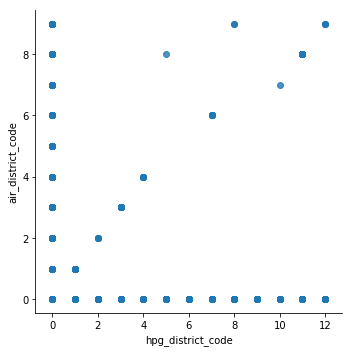

In [27]:
sns.lmplot(x='hpg_district_code', y='air_district_code', data=test, fit_reg=False)

In [29]:
vars(model)

{'algorithm': 'auto', 'cluster_centers_': array([[ 35.67606662, 139.68596163],
        [ 34.41078038, 132.61853767],
        [ 43.11093019, 141.61077642],
        [ 34.69771536, 135.35959866],
        [ 33.61330692, 130.48658965],
        [ 38.27630727, 140.87803302],
        [ 37.80503165, 138.99529063],
        [ 34.88477797, 138.17878161]]), 'copy_x': True, 'inertia_': 430.39539695278404, 'init': 'k-means++', 'labels_': array([3, 3, 3, ..., 0, 0, 3], dtype=int32), 'max_iter': 300, 'n_clusters': 8, 'n_init': 10, 'n_iter_': 1, 'n_jobs': 1, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

In [30]:
stores

,air_store_id,air_genre_name,air_area_name,latitude_air,longitude_air,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg,hpg_area_city,hpg_area_district,hpg_area_extra,air_area_city,air_area_district,air_area_extra,lat,lng,predicted_region
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN,None,None,None,Hyōgo-ken,Kōbe-shi,Kumoidōri,34.695124,135.197852,3
1,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN,None,None,None,Hyōgo-ken,Kōbe-shi,Kumoidōri,34.695124,135.197852,3
2,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN,None,None,None,Hyōgo-ken,Kōbe-shi,Kumoidōri,34.695124,135.197852,3
3,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
4,air_99c3eae84130c1cb,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
5,air_f183a514cb8ff4fa,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
6,air_6b9fa44a9cf504a1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
7,air_0919d54f0c9a24b8,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
8,air_2c6c79d597e48096,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
9,air_0164b9927d20bcc3,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,None,None,None,Tōkyō-to,Minato-ku,Shibakōen,35.658068,139.751599,0
